In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
data <- read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vSTyupJYW8-dOI7rTKOVE-bMT4M_8UnVnRLOJGavyVh33-4wHTkP4Q-uWX9mwMQul2kxMl8aJLR0FHB/pub?output=csv")

Parsed with column specification:
cols(
  .default = col_double(),
  url = col_character()
)

See spec(...) for full column specifications.



In [5]:
named_data <- data %>%
    rename(
        monday = weekday_is_monday,
        tuesday = weekday_is_tuesday,
        wednesday = weekday_is_wednesday,
        thursday = weekday_is_thursday,
        friday = weekday_is_friday,
        saturday = weekday_is_saturday,
        sunday = weekday_is_sunday,
        lifestyle = data_channel_is_lifestyle,
        entertainment =  data_channel_is_entertainment,
        business = data_channel_is_bus,
        society_and_medicine =  data_channel_is_socmed,
        technology =  data_channel_is_tech,
        world =  data_channel_is_world
    )


In [15]:
tidy_data <- named_data %>%
    pivot_longer(cols =  lifestyle:world, 
                 names_to = 'Genre', 
                 values_to = 'Genre_Present') %>%
    filter(Genre_Present == 1) %>%
    pivot_longer(cols =   monday:sunday, 
                 names_to = 'Day_Of_Week', 
                 values_to = 'Day_Present') %>%
    filter(Day_Present == 1) %>%
    mutate(Genre = as_factor(Genre)) %>%
    mutate(Day_Of_Week = as_factor(Day_Of_Week)) %>%
    select(Genre, Day_Of_Week, shares, num_imgs)

head(tidy_data)

Genre,Day_Of_Week,shares,num_imgs
<fct>,<fct>,<dbl>,<dbl>
entertainment,monday,593,1
business,monday,711,1
business,monday,1500,1
entertainment,monday,1200,1
technology,monday,505,20
technology,monday,855,0


In [16]:
set.seed(1234)
publishing_split <- initial_split(tidy_data, prop = 0.6, strata = shares)
publishing_train <- training(publishing_split)
publishing_test <- testing(publishing_split)

head(publishing_train)

day_table <- publishing_train %>%
    group_by(Day_Of_Week) %>%
    summarize(total_articles=n(), avg_shares=mean(shares), num_imgs = mean(num_imgs))
day_table

genre_table <- publishing_train %>%
    group_by(Genre) %>%
    summarize(total_articles=n(), avg_shares=mean(shares), num_imgs = mean(num_imgs))
genre_table

Genre,Day_Of_Week,shares,num_imgs
<fct>,<fct>,<dbl>,<dbl>
entertainment,monday,593,1
business,monday,711,1
entertainment,monday,1200,1
technology,monday,855,0
technology,monday,891,20
world,monday,710,1


`summarise()` ungrouping output (override with `.groups` argument)



Day_Of_Week,total_articles,avg_shares,num_imgs
<fct>,<int>,<dbl>,<dbl>
monday,3439,2999.235,3.990404
tuesday,3751,2866.669,3.912823
wednesday,3847,2861.583,3.515986
thursday,3747,2674.814,3.799573
friday,2799,2787.569,3.663451
saturday,1213,3500.322,4.968673
sunday,1312,3540.827,5.084604


`summarise()` ungrouping output (override with `.groups` argument)



Genre,total_articles,avg_shares,num_imgs
<fct>,<int>,<dbl>,<dbl>
entertainment,4271,2881.035,6.108640
business,3733,3066.073,1.845968
technology,4493,3095.890,4.423325
lifestyle,1230,3587.873,4.857724
world,4990,2304.479,2.796794
society_and_medicine,1391,3752.208,4.549964


In [17]:
share_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
       set_engine("kknn") %>%
       set_mode("regression") 

share_recipe <- recipe(shares ~ ., data = publishing_train) %>%
       step_scale(-shares, -Day_Of_Week, -Genre) %>%
       step_center(-shares, -Day_Of_Week, -Genre)


In [19]:
shares_vfold <- vfold_cv(publishing_train, v = 5, strata = shares)

share_workflow <- workflow() %>%
       add_recipe(share_recipe) %>%
       add_model(share_spec)

gridvals <- tibble(neighbors = 100 : 250)

share_results <- share_workflow %>%
    tune_grid(resamples = shares_vfold, grid = gridvals) %>%
    collect_metrics()

share_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
100,rmse,standard,8.551280e+03,5,2.123013e+03,Model001
100,rsq,standard,5.264570e-03,5,1.063338e-03,Model001
101,rmse,standard,8.549250e+03,5,2.123593e+03,Model002
101,rsq,standard,5.536913e-03,5,1.129523e-03,Model002
102,rmse,standard,8.548738e+03,5,2.123389e+03,Model003
102,rsq,standard,5.544803e-03,5,1.170209e-03,Model003
103,rmse,standard,8.549739e+03,5,2.123189e+03,Model004
103,rsq,standard,5.364198e-03,5,1.159156e-03,Model004
104,rmse,standard,8.549573e+03,5,2.123318e+03,Model005


In [20]:
share_min <- share_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean) %>% 
    slice(1)

share_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
235,rmse,standard,8536.207,5,2129.486,Model136


In [21]:
k_min <- share_min %>%
          pull(neighbors)

share_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
          set_engine("kknn") %>%
          set_mode("regression")

share_best_fit <- workflow() %>%
          add_recipe(share_recipe) %>%
          add_model(share_best_spec) %>%
          fit(data = publishing_train)

share_summary <- share_best_fit %>%
           predict(publishing_test) %>%
           bind_cols(publishing_test) %>%
           metrics(truth = shares, estimate = .pred)
share_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,9.316803e+03
rsq,standard,7.738050e-03
mae,standard,2.421295e+03


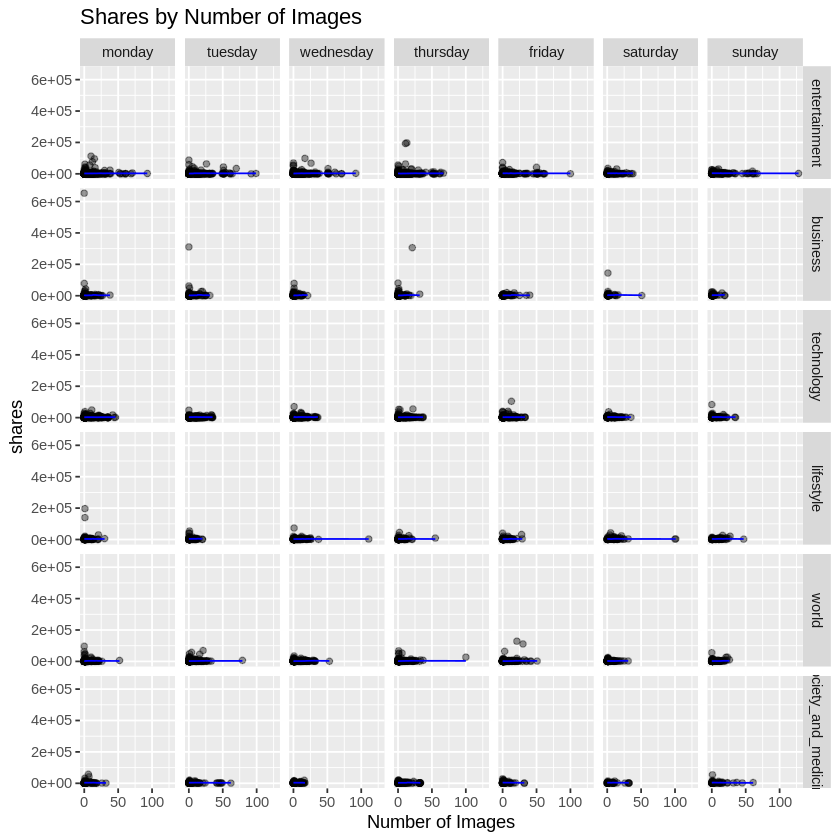

In [22]:
share_preds <- share_best_fit %>%
           predict(publishing_test) %>%
           bind_cols(publishing_test)

options(repr.plot.width = 7, repr.plot.height = 7)

share_plot <- ggplot(share_preds, aes(x = num_imgs, y = shares)) +
  geom_point(alpha = 0.4) +
  labs(x="Number of Images")+
  geom_line(data = share_preds, aes(x = num_imgs, y = .pred), color = "blue")+
  facet_grid(Genre ~ Day_Of_Week)+
  ggtitle("Shares by Number of Images")
share_plot